In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 7s 153ms/step - loss: 0.0514 - val_loss: 0.0014
Epoch 2/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0098 - val_loss: 5.6798e-04
Epoch 3/100
19/19 [==============================] - 2s 105ms/step - loss: 0.0016 - val_loss: 3.0159e-04
Epoch 4/100
19/19 [==============================] - 2s 104ms/step - loss: 0.0010 - val_loss: 2.7463e-04
Epoch 5/100
19/19 [==============================] - 2s 98ms/step - loss: 8.1348e-04 - val_loss: 1.9731e-04
Epoch 6/100
19/19 [==============================] - 2s 99ms/step - loss: 7.4926e-04 - val_loss: 3.1127e-04
Epoch 7/100
19/19 [==============================] - 2s 103ms/step - loss: 6.9530e-04 - val_loss: 2.8928e-04
Epoch 8/100
19/19 [==============================] - 2s 96ms/step - loss: 6.4658e-04 - val_loss: 2.4237e-04
Epoch 9/100
19/19 [==============================] - 2s 94ms/step - loss: 6.2222e-04 - val_loss: 1.6265e-04
Epoch 10/100
19/19 [========================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 12ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 26788.23695060204


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99916923271303
Testing MAE: 26639.728788623237


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.23125626146793365], [0.23156894743442535], [0.23193146288394928], [0.2323228120803833], [0.23273512721061707], [0.23316414654254913], [0.23360683023929596], [0.23406082391738892], [0.23452438414096832], [0.23499591648578644], [0.23547425866127014], [0.23595836758613586], [0.23644742369651794], [0.23694075644016266], [0.23743773996829987], [0.2379380315542221], [0.23844125866889954], [0.23894700407981873], [0.23945504426956177], [0.23996520042419434], [0.24047726392745972], [0.24099101126194], [0.2415064126253128], [0.2420233190059662], [0.2425416260957718], [0.24306122958660126], [0.2435821145772934], [0.24410414695739746], [0.24462734162807465], [0.2451515942811966], [0.24567684531211853], [0.24620313942432404], [0.24673038721084595], [0.2472585141658783], [0.24778757989406586], [0.24831745028495789], [0.24884817004203796], [0.24937966465950012], [0.24991197884082794], [0.2504449486732483], [0.2509786784648895], [0.2515130937099457], [0.25204816460609436], [0.25258389115333557], [

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27776.00670614],
       [27804.65027284],
       [27837.85846434],
       [27873.70796834],
       [27911.47805462],
       [27950.77832762],
       [27991.33032339],
       [28032.91836887],
       [28075.38275679],
       [28118.57743009],
       [28162.39591724],
       [28206.74266689],
       [28251.54260298],
       [28296.73429963],
       [28342.26042602],
       [28388.08958672],
       [28434.18765624],
       [28480.51641403],
       [28527.05538481],
       [28573.78818834],
       [28620.69571435],
       [28667.75748755],
       [28714.9707779 ],
       [28762.32193521],
       [28809.80140434],
       [28857.39963016],
       [28905.11524764],
       [28952.93597162],
       [29000.86316711],
       [29048.88727897],
       [29097.00284713],
       [29145.21396665],
       [29193.51244741],
       [29241.89146431],
       [29290.35647744],
       [29338.89520161],
       [29387.51173188],
       [29436.19924317],
       [29484.96183052],
       [29533.78447872],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(320,)


(320, 1)

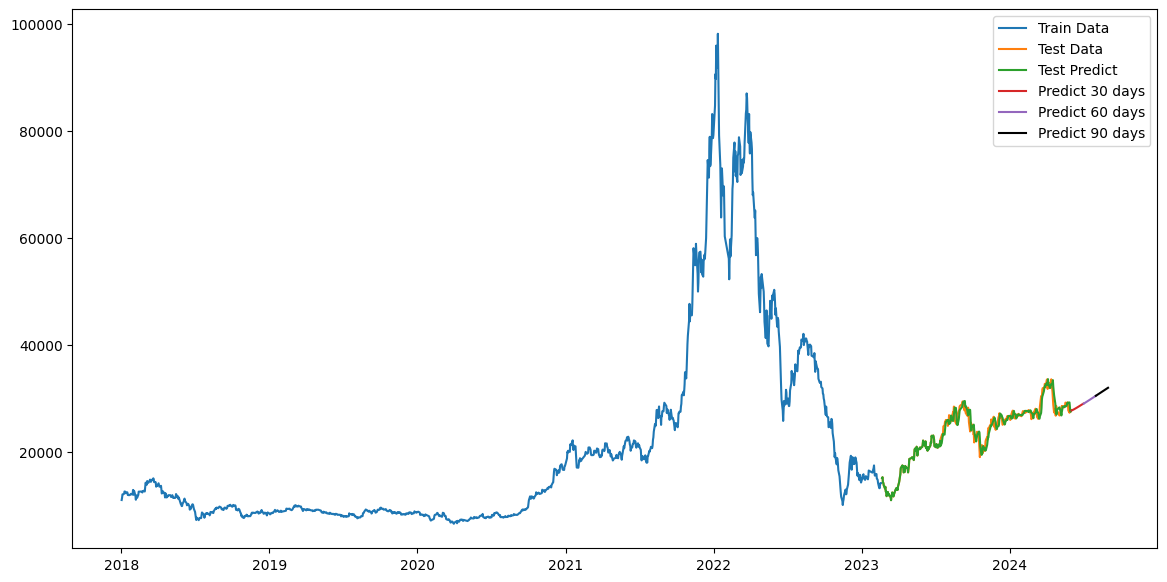

In [19]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()